# Handout #4: Evaluating AI Systems

Content Authors:


*   Chris Malone Ph D, Professor of Data Science and Statistics, Winona State University; Email: cmalone@winona.edu
*   Collin Engstrom PhD, Assistant Professor of Computer Science, Winona State University; Email: collin.engstrom@winona.edu

Content in this handout was adapted from the following sources.
*    https://www.tensorflow.org/tutorials/keras/classification
* https://colab.research.google.com/github/goodboychan/chans_jupyter/blob/main/_notebooks/2020-07-28-01-Breast-Cancer-Detection-with-Machine-Learning.ipynb
*    https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/
*    https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
*    Situnayake, Daniel, and Jenny Plunkett. *AI at the Edge*. "O'Reilly Media, Inc.", 2023.

## Libraries and Custom Functions

The following Python libraries will be used throughout this handout.

In [ ]:
# Load Numpy, MatPlot, Pandas, and Seaborn libraries for data processing and graphing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas.plotting import scatter_matrix
import seaborn as sns

# Load TensorFlow and Keres libraries to facilitate fitting of neural net
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Sci-Kit Learn Libraries to faciliate model fitting, metrics,
#from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

print('Tensorflow Version:' + tf.__version__)

Tensorflow Version:2.18.0


The following are custom functions that will be used in this handout.

In [ ]:
# Need a function that plots a confusion matrix for us
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [ ]:
#ROC Curve
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.1,1.1])
  plt.ylim([0,1.1])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Example #1: WI Breast Cancer

<table width='100%' ><tr><td bgcolor='green'></td></tr></table>

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. A brief description of some of the characteristics measured are considered here. The outcome of interest (i.e. the class variable) is whether or not cancer is present.

<table>
  <tr>
    <td width='100%'>
      <ul>
        <li><strong>Class</strong>: Labels are 0 (Benign) and 1 (Malignant)</li><br>
        <li><strong>Features</strong>:</li>
        <ul>
          <li>ID - unique ID for each sample</li>
          <li>CellClumpThickness - higher values indicate malignancy</li>
          <li>UniformCellSize - higher values suggest greater likelihood of malignancy</li>
          <li>UniformCellShape - higher values indicate more variability and potential malignancy</li>
          <li>MarginalAdhesion - lower values can be indicatvie to cancer</li>
          <li>SingleEpithelialSize - larger sizes my indicate malignancy</li>
          <li>BareNuclei - Counts the number of nuclei that are not surrounded by cytoplasm (higher values are often associated with cancer)</li>
          <li>BlandChromatin - Measure of texture of the cell nucleus chromatin (courser chromatin is typical in cancer cells)</li>
          <li>NormalNucleoli - Counts the number of nucleoli with the nucleus (higher values are linked to malignancy)</li>
          <li>Mitoses - Measures the number of cells undergoing mitosis (higher values are associated with malignancy)</li>
         </ul>
    </ul>
    </td>
</tr>
</table>

[Data - Local Copy](https://github.com/christophermalone/mayo_ml_workshop/blob/main/WI_BreastCancer.csv)

<p align='center'><img src="https://drive.google.com/uc?export=view&id=175xKGsxAKhQlul-CEMZiiTjCoR30Jny9" width='50%' height='50%'></img></p>

Image Source: https://sphweb.bumc.bu.edu/otlt/mph-modules/ph/ph709_cancer/ph709_cancer7.html

<table width='100%' ><tr><td bgcolor='green'></td></tr></table>


The following code will read in the WI Breast Cancer dataset.

In [ ]:
url= 'https://raw.githubusercontent.com/christophermalone/mayo_ml_workshop/refs/heads/main/datasets/WI_BreastCancer.csv'
WI_BreastCancer_DF = pd.read_csv(url)

In [ ]:
# @title Reading Data from Original Source

#Note: All lines commented out as local copy has been provided

#The following code can be used to read in this data from the original source
#url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
#names = ['id', 'clump_thickness', 'uniform_cell_size', 'uniform_cell_shape',
#         'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei',
#         'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']

#Reading in data; Use names as provided above, need to fix missingness issues, drop missing values
#WI_BreastCancer_DF = pd.read_csv(url, names=names).replace('?', np.nan).dropna()

# Convert classification labels to 0 and 1 (from 2 and 4)
#WI_BreastCancer_DF['class'] = WI_BreastCancer_DF['class']/2 - 1

The following are useful when reading in data.


*   .head() is used to view the first few rows of the data.frame
*   .shape will return the number of samples (rows) and number of fields (columns)
*   .dtypes will return the data type for each field

In [ ]:
WI_BreastCancer_DF.head()
#WI_BreastCancer_DF.shape
#WI_BreastCancer_DF.dtypes


,ID,CellClumpThickness,UniformCellSize,UniformCellShape,MarginalAdhesion,SingleEpithelialSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


## Investigating the Class variable

To begin, let's get a breakdown of the benign vs malignant cells for the samples in this dataset.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1_zgodOQ7SykjVCu95s0OOH169mpXaIYI" width='40%' height='40%'></img></p>



---


**Question**: What percent of the samples are cancerous?  

**Answer**:  The percent of samples that were malignant $\frac{239}{683} = 35\%$.



---




## Class Balance

The **balance** of the outcomes for the class variable is something that should be considered when building a neural net for classification.  If the labels (0 and 1) are too imbalanced, then a naive prediction can be made by simply identify the dominant label.  For example, in studies of rare diseases where a only small percentage of samples are positive, naively predicting a negative label will be correct for most people.  The opitimal class balance is 50/50 as the model fitting algorithm will have an equal opportunity to successfully predict both binary labels.

In [ ]:
# Find class balance
neg, pos = np.bincount(WI_BreastCancer_DF['Class'])
total = neg + pos
print('Samples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Samples:
    Total: 683
    Positive: 239 (34.99% of total)



Comments about class balance

*   There is not a widely accepted rule for when labels are deemed to be imbalanced; Some might argue that a 70/30 is imbalanced, whereas, others may use 85/15 as imbalanced
*   If outcomes of the class variable are deemed to be imbalanced, one can implement **upsampling** to address this issue.  Upsampling is a data processing technique that adds synthetic data to address class imbalance.


## Neural Net - The Big Picture

A neural net takes considers a set of **inputs** and returns a set of **output**.  The actual neural net is sometimes referred to as the infamous black box.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1D60dOSo7OUQ1zHe2ZDeZbWXeld_Ywbd8" width='80%' height='80%'></img></p>

The Class variable in this example has two labels 0 = Benign and 1 = Malignant.  This is **binary classificaiton** problem and the desired output from the neural net is the probability that a given sample is positive, i.e. probability of Label = 1 (Malignant).

This probability is determined using a model of the following form.

$$
P(y_{i} = k | X = x_i) = \phi_{o} ( \alpha_{k} + \sum_{h} {w_{h} * \phi_{h}(\alpha_{h}+\sum_{j=1}^{p}w_{jh}*x_{ij} ) )}
$$


where
*  $P(y_{i} = k | X = x_i)$ is the probability that Y belongs to class $k$ given a set of features $x_i = (x_{i1},x_{i2},\ldots, x_{ip}) $
* This represenation has $1$ hidden layer, $h$ represents the number of nodes in the hidden layer
*  $(\alpha_{h}+\sum_{j=1}^{p}w_{jh}*x_{ij} )$ is simply a weighted linear combination of the features
* $\phi_{h}()$ is an activation function that is applied on the hidden layer
* $\phi_{o}()$ is the *last* activation function that is applied



Consider the following overly simplistic example of a neural net.  This neural net has

*  two inputs,
*  1 hidden layer with 3 nodes, and
*  one output

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1RJZBU7kuzRDI8btyuAmUL6DXG7fYftfP" width='35%' height='35%'></img></p>


The neural net algorithm tries to identify optimal values for the weights so that the final predictions are as accurate as possible.  There are many weights that need to be considered.  The value computed at each node is simply a weighted linear combination.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1owrT3YzTPSGjFit-TVV11ZcvqS6lWJyD" width='50%' height='50%'></img></p>




Next, an activation function, i.e. $\phi_h()$, is applied at each node in the hidden layer.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1IhFYEqfFXf49CC56FaBfh4hlYFMLvkBb" width='50%' height='50%'></img></p>


There are many different types of activation functions (linear, relu, logistic, hyperbolic tanget, etc).  Recently, the most common activation function used is called **rectified linear unit (relu)**.  The relu activation function is advantageous as not all nodes are activiated which reduces the complexity when attempting to find the optimal weights.

[Wiki - Activation Functions](http://en.wikipedia.org/wiki/Activation_function)

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1wbGuXLC64qr8_9uHx1-JQ4omIlHQ1H_W" width='40%' height='40%'></img></p>


Next, applying the relu activation function to the nodes in the hidden layer.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=14nhUx4IPKF96PRZCjH7h0vS_t4tSMM4_" width='40%' height='40%'></img></p>


After the activiation function has been applied to the hidden layer, the network progresses forward.  Here, only 1 hidden layer is used, so the next layer is the *last* one.  For a classification problem, the last activiation function, i.e. $\phi_{o}$, should return a probability - so a value between $0$ and $1$.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1MegtqIMZTk1yb9dnr-3Z5Vdi9Zut-Xwt" width='50%' height='50%'></img></p>


The common activiation function for the last layer is the **sigmoid** function.  This function is guaranteed to return a value between $0$ and $1$.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1u0if_rqzNTE-VP5LOxnOc-Z6W4kahstT" width='40%' height='40%'></img></p>

Applying the sigmoid activiation function to the last layer of our simple neural network converts the value from $-14.67$ to $0.0376$.  

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1AEI_iiF1wJioKBMozWRTzayxtn_8sOyw" width='60%' height='60%'></img></p>



The value returned from the sigmoid activiation function is interpreted as the $P(y_i = 1 | X) = 0.0376$

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1YCxxZp66rh38oRbdFe3PqoinuYEC7uZJ" width='40%' height='40%'></img></p>


The collection of predicted probabilities across all samples is returned by the neural network.  In order to compute the effectivness of the model, these predicted probabilites must be used to predict the class label. This is done as follows -- the default value for the $\bf{threshold}$ is $0.50$.

$$
\begin{equation}
  \mbox{Predicted Label} =
    \begin{cases}
      0 & \mbox{if } P(y_i=1|X) < threshold\\
      1 & \mbox{if } P(y_i=1|X) \ge threshold
    \end{cases}       
\end{equation}
$$

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1codq5f4-rcATyElLHhNJzLSEu-kG6nwY" width='25%' height='25%'></img></p>




After a prediction has been made for each sample, we are now able to evalaute the model's predictive performance.  The **loss function** determines how the evaluation is to be done.  You may have heard of a squared-error loss function which is appropriate when the final prediction is numeric.  A **binary_crossentropy** loss function will be used when here as the final prediction is binary outcome.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1XFAtVCk9eQqZdCowWriFfk0iGhuelR48" width='25%' height='25%'></img></p>


After an initial pass has been made through the network, the nueral net will use **backpropagation** to make improvements to its predictive ability.  The backpropagation algorithm will carefully consider how the weights should be reestimated.  

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1MUQVAUVujYuaw4CVY3FHuPLxciqtdv47" width='60%' height='60%'></img></p>


Once the weights are updated, the neural network will proceed forward through the network, will reevaluate the predictive ability of the model, imply backpropagation, etc.  This iterative process continues many times until the algorithm has decided upon the weights which we hope produce the best possible predictions.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=17SNHIphpPXBIw19PV-vs8yqht_5-wpYU" width='50%' height='50%'></img></p>



## Data Preprocessing

The following steps will be taken in order to prepare our data for the nueral network algorithm.

*  The dataset will be separated into two pieces, $\bf{X}$ and $y$. $\bf{X}$ will contain all features that will be used as inputs. The $y$ vector will consist of the $Class$ variable.
*  The $ID$ column must be removed from $\bf{X}$

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1xkkzSocvg_ARm-nfQUZU0wDtiPZgSkDv" width='50%' height='50%'></img></p>


The following code will create the $\bf{X}$ data.frame that will be used as inputs into our neural network.  $\bf{X$ will be converted to a numpy array as this needed for Tensor Flow.

In [ ]:
X = WI_BreastCancer_DF.drop(['ID','Class'], axis=1).to_numpy()
#Looking at first few lines of the array
X[0:10]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1],
       [ 8, 10, 10,  8,  7, 10,  9,  7,  1],
       [ 1,  1,  1,  1,  2, 10,  3,  1,  1],
       [ 2,  1,  2,  1,  2,  1,  3,  1,  1],
       [ 2,  1,  1,  1,  2,  1,  1,  1,  5],
       [ 4,  2,  1,  1,  2,  1,  2,  1,  1]])

Recall, the neural network computes a weighted linear combination of the inputs for the first layer and a weighted linear combination of the node values thereafter.  The measurement **scale** of the features will certainly influence the selection of the weights.  If the scales vary across the features being considered, some type of scaling should be done before inputs are put into the neural network model fitting algorithm.

The $MinMaxScaler$ and the $StandardScaler$ are the most common approaches to scaling the columns of $\bf{X}$.

*  The $MinMaxScaler$ will scale all values of a particular feature between two predetermined values, e.g. $1-10$.
*  The $StandardScaler$ will scale the value of a particular feature to have a $Mean = 0$ and $St Dev = 1$; This is simply the $z-score$ transformation for each feature.



---



**Question**: Does scaling need to be done for our case?

**Answer**: No, scaling appears to have been done already for us.



In [ ]:
#Get a statistical summary of each feature in the X
#Need to convert back to df for .describe()
print(DataFrame(X).describe())

                0           1           2           3           4           5  \
count  683.000000  683.000000  683.000000  683.000000  683.000000  683.000000   
mean     4.442167    3.150805    3.215227    2.830161    3.234261    3.544656   
std      2.820761    3.065145    2.988581    2.864562    2.223085    3.643857   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      2.000000    1.000000    1.000000    1.000000    2.000000    1.000000   
50%      4.000000    1.000000    1.000000    1.000000    2.000000    1.000000   
75%      6.000000    5.000000    5.000000    4.000000    4.000000    6.000000   
max     10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   

                6           7           8  
count  683.000000  683.000000  683.000000  
mean     3.445095    2.869693    1.603221  
std      2.449697    3.052666    1.732674  
min      1.000000    1.000000    1.000000  
25%      2.000000    1.000000    1.000000  
50%   

array([[<Axes: xlabel='0', ylabel='0'>, <Axes: xlabel='1', ylabel='0'>,
        <Axes: xlabel='2', ylabel='0'>, <Axes: xlabel='3', ylabel='0'>,
        <Axes: xlabel='4', ylabel='0'>, <Axes: xlabel='5', ylabel='0'>,
        <Axes: xlabel='6', ylabel='0'>, <Axes: xlabel='7', ylabel='0'>,
        <Axes: xlabel='8', ylabel='0'>],
       [<Axes: xlabel='0', ylabel='1'>, <Axes: xlabel='1', ylabel='1'>,
        <Axes: xlabel='2', ylabel='1'>, <Axes: xlabel='3', ylabel='1'>,
        <Axes: xlabel='4', ylabel='1'>, <Axes: xlabel='5', ylabel='1'>,
        <Axes: xlabel='6', ylabel='1'>, <Axes: xlabel='7', ylabel='1'>,
        <Axes: xlabel='8', ylabel='1'>],
       [<Axes: xlabel='0', ylabel='2'>, <Axes: xlabel='1', ylabel='2'>,
        <Axes: xlabel='2', ylabel='2'>, <Axes: xlabel='3', ylabel='2'>,
        <Axes: xlabel='4', ylabel='2'>, <Axes: xlabel='5', ylabel='2'>,
        <Axes: xlabel='6', ylabel='2'>, <Axes: xlabel='7', ylabel='2'>,
        <Axes: xlabel='8', ylabel='2'>],
       [<Axes

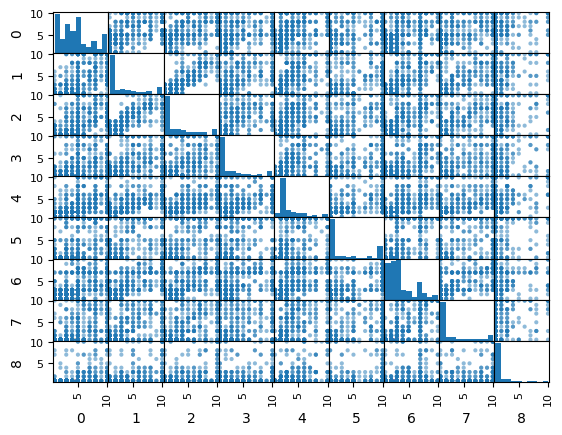

In [ ]:
#Create a scatterplot matrix of all features in X matrix
scatter_matrix(DataFrame(X))

The following code will create the $\bf{y}$ vector that will be used by our neural net algorithm. Again, $\bf{y}$ will be converted to an numpy array for Tensor Flow.

In [ ]:
y = WI_BreastCancer_DF['Class'].to_numpy()
y[0:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
# ensure the labels have been encoded to be integers
y = LabelEncoder().fit_transform(y)

## Validation

**Validation** is a concept that is used to ensure that a model is able to accurately predict new samples.  Validation helps ensure that your predictive model is not **overfitting** the data. Overfitting occurs when the model appears to have good predictive performance for the data used to build the model, but does not perfom well when given a new samples.

Validation partitions the data into two (or more) groups – one group is used to build the predictive model, and the other group(s) is used to evaluate the predictive ability of a model. There are a variety of approaches that can be used to partition the data into two (or more groups). Two of the more common validation methods are mentioned here.



For simplicity, suppose all observations from a data set are placed into a “hat”.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1_mdxVs4ZY2-7lz-XdtwYIOiaVJRrBYdU" width='15%' height='15%'></img></p>

**Split-Sample**: the observations are randomly divided into a training set and a test set

*  Training set: data that is used to build the predictive model
*  Test set: data that is used to evaluate the predictive performance of the model

<p align='center'><img src="https://drive.google.com/uc?export=view&id=13jQFbTGsBtGBuADRHEUemsxpNR9lX_UJ" width='20%' height='20%'></img><br>
<img src="https://drive.google.com/uc?export=view&id=1fsVJuD_YJei555J85NLAcdEwFiC93qt-" width='35%' height='35%'></img></p>

Some comments about split-sample:

*  A 75% : 25% split is often used for split-sample cross-validation; 75% of the observations are put into the training set and the remaining 25% are put into the test set. Variations to these proportions are common, e.g. 80% : 20% or 67% : 33%, etc.
*  The predictive performance of the model is measured using a subset of the observations, i.e. only the observations in the test set. This simulates how our model would theoretically perform on "new" data points.
*  Split-sample is one of the simpliest methods for doing cross-validation.  One short-coming of split-sample is that not all observations are used to build the predictive model.
*  Problem is that bias creeps in if train-test split is not representative of population.
*  Better approach is to use $k$-fold cross-validation.



---



**k-Fold Cross-Validation**: the data is randomly partitioned into $k$
 distinct folds (i.e. groups) – each fold should have about the same number of observations.  Here, the data has been divided into 5
 distinct folds, i.e. $5-Fold$ cross-validation.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1nd8Z3h0Mj2PIke_3kU8Bx9N6wV4xdB9P" width='20%' height='20%'></img></p>

*  A predictive model is built using all folds except 1. The predictive performance of the model is evaluated using the fold withheld from the model building step. This process is repeated across all folds.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1lHffSOL6MfFZjldatqoqJGRGJFgXxKaU" width='40%' height='40%'></img></p>


<p align='center'><img src="https://drive.google.com/uc?export=view&id=1HJv470iV-Knoti_KC8oEo9Z-UrP_YN8R" width='40%' height='40%'></img></p>

$$\huge Etc$$

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1s3V9BM6UJawWeKD3D0pXdXi-AT73tPRG" width='40%' height='40%'></img></p>

*  Most often the value of $k$ ranges from $5$ to $10$ for $k$-Fold cross-validation.
* A total of $k$ predictive models are constructed; the predictive models will vary from one fold to the next.  $K$-Fold cross-validaiton is more computationally intensive than split-sample.
* A $k$-Fold cross-validation process ensures that predictions are made once for all observations.
* For small datasets, bias may still be a concern. In this case, set $k$ equal to the number of instances. This way $k$ train-test iterations will occur. On each iteration, a different one of the $k$ instances is held out as the single test point. This is called **leave-one-out cross-validation**.




---



For this example, we will use a split-sample cross-validation approach.  The split-sample will use $75\%$ of the samples for the training set and $25\%$ of the samples for the test set, i.e. a $75:25$ specification.

In [ ]:
# Partion data into training set and test set
# shuffle = True ensures samples are randomly selected for each set
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                                    test_size=0.25,
                                                    shuffle=True)

## Fitting the Neural Net

In this handout, the nueral network will be fit using Tensor Flow + Keres.  There are four distinct components when fitting a nueral network model with Tensor Flow + Keras.

1.   Model specification
2.   Compiling the model
3.   Fitting the model

### 1. Model Specification

The number of features in $\bf{X}$ will be needed in the model specification step.

In [ ]:
# determine the number of input features
n_features = X_train.shape[1]
print(n_features)

9


Our neural network model will be initiated using the following. This allows one to build models layer-by-layer which is referred to a linear stack of layers.

*model = Sequential()*


The $1^{st}$ hidden layer will be specified as follows.

*model.add(Dense(# Nodes, activation='relu', kernal_initializer='he_normal', input_shape = # Features) )*

where
 * \# Nodes is the number of desired nodes in the first hidden layer
 * The $relu$ activation function that will be used in this layer
 * The kernal_initalizer determines how weights are initially computed.  Most suggest that $he\_normal$ is best when using $relu$ as the activation function
 * The number of features is contained in variable $n\_features$

The $2^{nd}$ hidden layer of the network follows from the $1^{st}$ layer.  The number of features does not need to be passed onto the $2^{nd}$ layer.

Recall, the *last* layer in a neural network that is used for classification must return a probability.  Thus, a single node is used with the activiation function set to *sigmoid*.

*model.add(Dense(1, activation='sigmoid'))*

In [ ]:
# Initiate the model
model = Sequential()

# Two layers of 10 and 8 nodes, respectively
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))

# Last layer will be one node and output a probability value in the range [0,1]
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 2. Complier Specification

There are three parameters that will be passed into the complier.

*   optimizer: identifies the gradient decent method to use; here Stochastic gradient descent (sgd) will be used as this approach is computationally efficient
*   loss: specifies the type of loss function to use when evaluating model performance; here $binary\_crossentropy$ as the Class variable is binary
*   metrics: Area Under Curve (auc) and Accuracy will be the model performance metrics that will be returned by the compiler

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1sD_Yn5Ot-jK9yWparhxulx-2J9Xc7NIU" width='50%' height='50%'></img></p>

Image Source: https://easyai.tech/en/ai-definition/gradient-descent/

In [ ]:
# Specification of the compiler for the nueraul network model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['auc','accuracy'])

### 3. Fitting the Model

Recall, only the *training* data is used to build the model thus it is passed into the model fitting algorithm.  

*  Specify the features and class variable from the training set
*  batch_size: this specifies how many samples are pushed through the neural network at one time; using a small batch_size can greatly improve the efficiency of the model fitting algorithm
*  epochs: this specifies the number of "backpropagation -> update weights -> fit -> evaluate performance" cylces are done; usually epoches is no more than 100

In [ ]:
# fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

## Model Performance Metrics

After a model has been fit using the *training* data, interest lies in the model's ability to make valid predictions for a new set of data, i.e. the *test* data.  Two common metrics that are be used to evaluate a model's predictive ability are considered here.

*  **Accuracy**: the proportion of predictions that were correct

$$\mbox{Accuracy} = \frac{\mbox{Correct Predictions}}{\mbox{Total Predictions}}$$

* **Understanding Accuracy**:  Accuracy is the simpliest metric one could use for evaluating model performance. Realize that flipping-a-coin will produce $50\%$ accuracy for a binary classification problem.  Furthermore, when the labels within the Class variable are imbalanced, model accuracy should prefer better than predicting all labels as positive or predicting all labels as negative.

*  **Area Under ROC**: an ROC curve considers both the sensitivity (true positive rate) and complement of specificity, i.e. ($1 - \mbox{true negative rate}$), of the predictions from the model.    

$$\mbox{Sensitivity} = \frac{\mbox{Correct Positive Predictions}}{\mbox{Correct Positive Predictions + Incorrect Positive Predictions}}$$

$$(1-\mbox{Specificity}) = \bigr( 1 - \frac{\mbox{Correct Negative Predictions}}{\mbox{Correct Negative Predictions + Incorrect Negative Predictions}} \bigl)$$


*  **How to Read an ROC Plot**

1.   A ROC plot displays the relationship between $Sensitivity$ and $(1-Specificity)$.  We want $Sensitivity$ to be high and $(1-Specificity)$ to be low.  
2.   The threshold value that produces the point closest to the upper-right hand corner in the plot is considered to be the optimial threshold value.
3.   The Class variable is binary, thus simply flipping-a-coin will result in half of the predictions be correct.  A good predicitive model will have a large amount of area under the ROC curve.
4. Area Under ROC can be used to compare the performance across a variety of machine learning algorithms.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1m66adnfoWpPO52t2JiY4ArXEkgQd34Ry" width='35%' height='35%'></img></p>


**Additional notes:**

* $Sensitivity$ (y-axis) is often referred to as the *True Positive Rate* (or *TPR* for short).
* $1-Specificity$ (x-axis) is often referred to as the *False Positive Rate* (or *FPR* for short).



---



Situation \#1: Using a threshold value of $50\%$:

Observations from Situation #1:

* A total of $68$ samples had a predicted probability above $50\%$.  Thus, $68$ samples were predicted to be malignant by the nueral net model.
* Of the $68$ samples that were predicted to be malignant, $65$ were correct and $3$ were incorrect.
* A total of $103$ samples had a a predicted probability below $50\%$.  Thus, $103$ samples were predicted to be benign by the nueral net model.
* Of the $103$ samples that were predicted to be benign, $96$ were correct and $7$ were incorrect.


<p align='center'><img src="https://drive.google.com/uc?export=view&id=155bFPWVif2m2ZBF35vCgoM1GXW8bbfxe" width='40%' height='40%'></img></p>


These correct and incorrect predictions are provided in the table below.  This table is commonly referred to as a **confusion matrix**.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1BicW3tyEODehplN0TN5C6vRq_4hBa4Ym" width='25%' height='25%'></img></p>

The accuracy metric for this confusion matrix is computed as follows.

$$\begin{array}{rcl}
Accuracy & = & \frac{\mbox{Correct Predictions}}{\mbox{Total Predictions}} \\
& = & \frac{(96+65)}{(96+3+7+65)} \\
& = & \frac{161}{171} \\
& = & 94.2 \% \\ \end{array}$$

Furthermore, consider the calculation for $Sensitivity$

$$\begin{array}{rcl}
Sensitivity & = & \frac{\mbox{65}}{\mbox{7+65}} \\
& = & \frac{65}{72} \\
& = & 90.3 \% \\ \end{array}$$

and for and $(1-Specificity)$


$$\begin{array}{rcl}
(1-Specificity) & = & 1- (\frac{\mbox{96}}{\mbox{96+3}}) \\
& = & 1 - 0.97 \\
& = & 3 \% \\ \end{array}$$



---



Situation \#2: Using a threshold value of $60\%$:

<p align='center'><img src="https://drive.google.com/uc?export=view&id=16aaE3YyEef6hgUztBTRNT9yd2xldOMTk" width='65%' height='65%'></img></p>



Performance Measures when using a threshold of $60\%$.

*  $Accuracy = 93.6\%$
*  $Sensitivity = 87.5\%$ and $(1 - Specificity) = 2\%$



---



Situation #3: Using a threshold value of  10% :

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1_XADZ5aPEM9N7vGWJ_yzLOLHQbztSLao" width='65%' height='65%'></img></p>


Performance Measures when using a threshold of $10\%$.

*  $Accuracy = 86.5\%$
*  $Sensitivity = 98.6\%$ and $(1 - Specificity) = 22.2\%$



---



Situation #4: Using a threshold value of  100% (predicting all samples to be Benign):

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1NTfpDpECMQqnkkpl11AjAGFzblYuq0C6" width='65%' height='65%'></img></p>


Performance Measures when using a threshold of $100\%$.

*  $Accuracy = 57.9\%$
*  $Sensitivity = 0.0\%$ and $(1 - Specificity) = 0.0\%$

Comment:  Predicting the Class variable as Benign for all samples will be correct $58\%$ of time.  Thus, the gain in performance accuracy should be evaluated against $58\%$.



---



Now, let's re-consider the predictions from Scenario 3 above:
<br><br>
<p align='center'><img src="https://drive.google.com/uc?export=view&id=18BIPifworiugPOtWP7MxTgtvVDzj-PCq" width='65%' height='65%'></img></p>

Note that all 93 instances in the shaded region will be classified as "malignant" given the 10% threshold. The red instances in the shaded region are **true positives**, while the green ones are **false positives**. The red instances in the unshaded region are **false negatives**, while the green ones are **true negatives**.
<br><br>
In certain circumstances, we might want to determine how many of these predictions are "true positives." In such circumstances, we can use one of a few metrics:
<br><br>
$$\begin{array}{rcl}
Precision  & = & \frac{\mbox{Correct Malignant Predictions}}{\mbox{Total Malignant Predictions}} \\
& = & \frac{71}{(71+22)} \\
& = & \frac{71}{93} \\
& \approx & 0.763 \\ \end{array}$$
<br><br>
$$\begin{array}{rcl}
Recall  & = & \frac{\mbox{Correct Malignant Predictions}}{\mbox{Total Malignant Instances}} \\
& = & \frac{71}{(71+1)} \\
& = & \frac{71}{72} \\
& \approx & 0.986 \\ \end{array}$$
<br><br>
$$\begin{array}{rcl}
F_1  & = &  2 * \frac{\mbox{precision * recall}}{\mbox{precision + recall}} \\
& = & 2 * \frac{(0.763 * 0.986)}{(0.763 + 0.986)} \\
& \approx & 2 *  0.43 \\
& = & 0.86  \\ \end{array}$$
<br><br>
We will want to choose *precision* for applications where you are more concerned about **false positives**. Choose *recall* for applications where you are more concerned with **false negatives**.





---



## Making Predictions for the Test Set

The model.predict() object can be used to make predictions with your nueral network model.  Model performance should be evaluated on the *test* dataset; thus, the features from the *test* dataset are passed into model.predict in this code.

In [ ]:
# Getting predictions for the features in the test set
Predictions_Test = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [ ]:
#Taking a quick look at the predictions
print(DataFrame(Predictions_Test))

            0
0    0.130649
1    0.799084
2    0.411632
3    0.036178
4    0.953073
..        ...
166  0.992257
167  0.986323
168  0.596683
169  0.995149
170  0.010809

[171 rows x 1 columns]




---



## Computing Model Performance Metrics

The following code can be be used to compute $Accuracy$ and $Area \, Under \, ROC$.  These metrics should be computed on the *test* set.

In [ ]:
# Using model.evaluate to obtain acc and auc
losstest, acctest, auctest  = model.evaluate(X_test, y_test, verbose=0)

print('Model Accuracy for Test Set: %.3f' % acctest)
print('Area Under Curve for Test Set: %.3f' % auctest)

Model Accuracy for Test Set: 0.981
Area Under Curve for Test Set: 0.947


The following code can be used to create an $ROC \, Plot$. This code uses the custom plot_roc() function provided above.

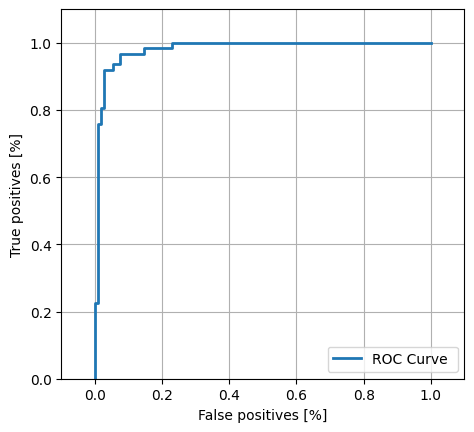

In [ ]:
# Do an ROC curve
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("ROC Curve ", y_test, Predictions_Test, color=colors[0])
plt.legend(loc='lower right');

The following code can be used to create a confusion matrix / plot. This code uses the custom plot_cm() function provided above.  The parameters of this function include the actual class values, the predicted class values, and specification of the threshold that is used to make label predictions for the Class variable.

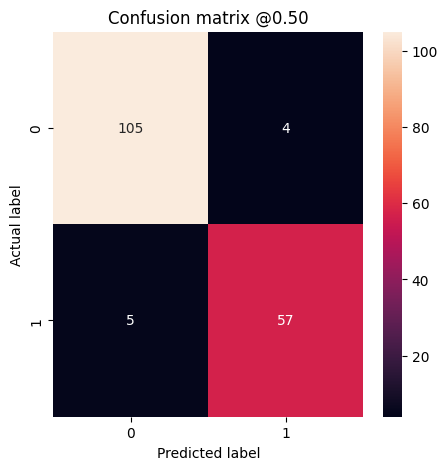

In [ ]:
plot_cm(y_test, Predictions_Test, threshold = 0.50)



---



## Tuning the Parameters

**Tuning parameters** are settings within a model that can be manually adjusted by the user to optimize the model's performance for a specific problem.  Tuning parameters can be thought of as fine-tuning the model's behavior in order to obtain better results.

Relevant tuning parameters that could be adjusted in this nueral net include:

Model Specification:
* Adjusting the number of hidden layers
* Adjusting the number of nodes for the hidden layers
* Use a different activiation function
* Use a different kernel_initializer

Compliler Specification:
* Use a different optimizer for the gradient decent
* Consider changing the learning rate - the learning rate specifies to what degree the weights are allowed to change from one iteration to the next

Model Fitting:
* Adjust the number of epochs
* Adjust the batch_size




---



---


The End...

